In [4]:
!pip install pandas

In [1]:
!pip install librosa scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Cross-Validation Accuracy: 0.77 ± 0.03
Test Set Accuracy: 0.84

Classification Report (Train Set):
               precision    recall  f1-score   support

        bird       0.82      0.80      0.81       151
         cat       0.72      0.76      0.74       165
         dog       0.77      0.74      0.76       172

    accuracy                           0.77       488
   macro avg       0.77      0.77      0.77       488
weighted avg       0.77      0.77      0.77       488


Classification Report (Test Set):
               precision    recall  f1-score   support

        bird       0.82      0.88      0.85        42
         cat       0.85      0.83      0.84        42
         dog       0.83      0.79      0.81        38

    accuracy                           0.84       122
   macro avg       0.84      0.83      0.83       122
weighted avg       0.84      0.84      0.84       122



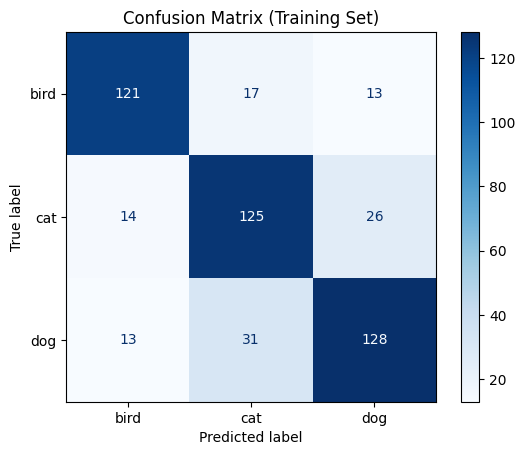

In [15]:
# Import necessary libraries
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Define the path to the "Animals" folder in your Google Drive
base_path = '/content/gdrive/MyDrive/Animals'

# Labels for the three categories
categories = ['bird', 'cat', 'dog']

# Function to extract MFCC features from an audio file
def extract_mfcc(file_path):
    audio_data, sample_rate = librosa.load(file_path, sr=None)  # Load the audio file
    mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)  # Extract 13 MFCC features
    mfcc_mean = np.mean(mfcc.T, axis=0)  # Mean of MFCCs across time
    return mfcc_mean

# List to hold features and labels
features = []
labels = []
file_names = []

# Loop through each category (bird, cat, dog)
for category in categories:
    folder_path = os.path.join(base_path, category)  # Path to the specific animal folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):  # Ensure we're only reading audio files
            file_path = os.path.join(folder_path, file_name)
            mfcc_features = extract_mfcc(file_path)
            features.append(mfcc_features)
            labels.append(category)
            file_names.append(file_name)  # Store file name

# Convert features and labels to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

# Define K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Use Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Perform K-fold cross-validation
y_pred_cv = cross_val_predict(gb_classifier, X_train, y_train, cv=kf)
cv_scores = cross_val_score(gb_classifier, X_train, y_train, cv=kf, scoring='accuracy')

# Calculate metrics for training set
accuracy = accuracy_score(y_train, y_pred_cv)
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_cv, average='weighted')

# Confusion matrix and classification report for training set
confusion_mat = confusion_matrix(y_train, y_pred_cv)
class_report = classification_report(y_train, y_pred_cv)

# Fit the model on the entire training set
gb_classifier.fit(X_train, y_train)

# Evaluate on the test set
y_pred_test = gb_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_class_report = classification_report(y_test, y_pred_test)

# Print results
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
print(f"Test Set Accuracy: {test_accuracy:.2f}")
print("\nClassification Report (Train Set):\n", class_report)
print("\nClassification Report (Test Set):\n", test_class_report)

# Confusion matrix display for training set
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=np.unique(labels))
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix (Training Set)')
plt.show()
